## YOUTUBE SPAM DETECTION

In this  project,  with  a  given  public  set  ofYouTube  comments  collected  for  spam  research,  different  approaches  for  classifying  spam  arecreated and compared.  The initial set consists of 5 datasets composed by 1,956 real messagesextracted from five videos that were among the 10 most viewed on the collection period

### Imports


In [ ]:
!pip install transformers

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords 
import nltk 
from nltk.tokenize import sent_tokenize
import spacy
import re
import nltk
import torch
import torch.nn as nn
import transformers as ppb
from sklearn.model_selection import train_test_split
from transformers import AutoModel, BertTokenizerFast
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn import metrics
import numpy as np
from sklearn.naive_bayes import MultinomialNB
import numpy as np
from sklearn.metrics import classification_report
import tensorflow as tf
import os
from transformers import BertTokenizer, TFBertForSequenceClassification
from sklearn.metrics import *
import seaborn as sns

nltk.download('stopwords')
nltk.download('punkt')
stop_words = set(stopwords.words('english'))
sp = spacy.load('en_core_web_sm')
tf_idf_vectorizer = TfidfVectorizer()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


### Data Analysis and Preprocessing

Combining data

In [ ]:
csvs = ['https://raw.githubusercontent.com/vitalijusC/youtube_spam/main/Youtube01-Psy.csv',
       'https://raw.githubusercontent.com/vitalijusC/youtube_spam/main/Youtube02-KatyPerry.csv',
       'https://raw.githubusercontent.com/vitalijusC/youtube_spam/main/Youtube03-LMFAO.csv',
       'https://raw.githubusercontent.com/vitalijusC/youtube_spam/main/Youtube04-Eminem.csv',
       'https://raw.githubusercontent.com/vitalijusC/youtube_spam/main/Youtube05-Shakira.csv']

data = []
for csv in csvs:
  data.append(pd.read_csv(csv))
data = pd.concat(data) 

In [ ]:
metrics_columns = ['Algorithm','Accuracy',
                   'ROC_AUC', 'F1', 'APS',
                   'Sensitivity', 'Specificity',
                   ]
metrics_df = pd.DataFrame(columns = metrics_columns)
matrices = []

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1956 entries, 0 to 369
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   COMMENT_ID  1956 non-null   object
 1   AUTHOR      1956 non-null   object
 2   DATE        1711 non-null   object
 3   CONTENT     1956 non-null   object
 4   CLASS       1956 non-null   int64 
dtypes: int64(1), object(4)
memory usage: 91.7+ KB


Checking for all the null values

In [ ]:
data.isnull().sum()

COMMENT_ID      0
AUTHOR          0
DATE          245
CONTENT         0
CLASS           0
dtype: int64

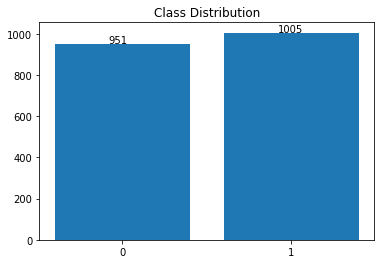

In [ ]:
count = data['CLASS'].value_counts()
plt.bar([1, 0], [count[1], count[0]], tick_label = ['1', '0'], )
plt.title("Class Distribution")
xlocs, xlabs = plt.xticks()
for i, v in enumerate(count):
    plt.text(xlocs[i] - 0.08, v+5, str(v))
plt.show()

Checking number of unique authors

In [ ]:
data['AUTHOR'].nunique()

1792

Dropping unnecessary data

In [ ]:
to_drop = ['COMMENT_ID', 'AUTHOR', 'DATE']
for column in to_drop:
  data.drop(column,axis=1,inplace=True)

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1956 entries, 0 to 369
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   CONTENT  1956 non-null   object
 1   CLASS    1956 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 45.8+ KB


In [ ]:
data.head()

,CONTENT,CLASS
0,"Huh, anyway check out this you[tube] channel: ...",1
1,Hey guys check out my new channel and our firs...,1
2,just for test I have to say murdev.com,1
3,me shaking my sexy ass on my channel enjoy ^_^ ﻿,1
4,watch?v=vtaRGgvGtWQ Check this out .﻿,1


Now, the preprocessing stage. It is is an important step as rawdata can have missing,  noisy or inconsistent data.  Without preprocessing the final predictionmight be harmfully influenced by faulty insights.  The result of data preprocessing is the final training set which is given as an input to predictive models and the testing set. Data preprocessing in this project includes tokenization, lower-casing, removing stop-words, lemmatizing and feature extraction. Lemmatizing  was  preferred  over  stemming,  as  it  converts  the  word  to  its  meaningful  baseinstead  of  only  removing  the  last  few  characters  of  words  as  it  is  done  in  stemming.   As  thefeature extraction, a TF-IDF was chosen as it contains information on the importance of wordsand overall shows better results than Bag of Words.





In [ ]:
def process_comment(comment):
  comment_alphabetical = " ".join(re.findall(r"(?i)\b[a-z]+\b", comment)).lower()  # extract only alphabetical words and lower
  comment_processed = ' '.join([token.lemma_ for token in sp(comment_alphabetical) if not token in stop_words]) # filter stop words and lemmatize
  return comment_processed
  # return ' '.join(comment_processed)


In [ ]:
data['CONTENT'] = data['CONTENT'].apply(process_comment)

In [ ]:
data.head()

,CONTENT,CLASS
0,huh anyway check out this -PRON- tube channel,1
1,hey guy check out -PRON- new channel and -PRON...,1
2,just for test i have to say murdev com,1
3,-PRON- shake -PRON- sexy ass on -PRON- channel...,1
4,watch v vtarggvgtwq check this out,1


In [ ]:
data_content_tfidf = tf_idf_vectorizer.fit_transform(data['CONTENT'])

As an output, we receive a [1956x3404] matrix, which means that there are 1956 comments and 3404 words across all the comments

In [ ]:
data_content_tfidf

<1956x3404 sparse matrix of type '<class 'numpy.float64'>'
	with 23670 stored elements in Compressed Sparse Row format>

In [ ]:
X = data_content_tfidf.toarray()
y = data['CLASS']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=24)

Class distribution in the combined dataset

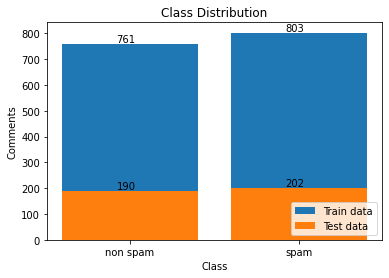

In [ ]:
unique, counts = np.unique(y_train, return_counts=True)
plt.bar(unique, counts, tick_label = ['non spam', 'spam'])
xlocs, xlabs = plt.xticks()
for i, v in enumerate(counts):
    plt.text(xlocs[i] - 0.08, v+5, v)
unique, counts = np.unique(y_test, return_counts=True)
xlocs, xlabs = plt.xticks()
for i, v in enumerate(counts):
    plt.text(xlocs[i] - 0.08, v+5, v)
plt.bar(unique, counts, tick_label = ['non spam', 'spam'])

plt.title('Class Distribution')
plt.xlabel('Class')
plt.ylabel('Comments')
plt.legend(('Train data', 'Test data'), loc=4)
plt.show()

### Model Training


#### Sklearn Multinomial Bayes
Used to compare an implemented version results

In [ ]:
clf = MultinomialNB()
clf.fit(X_train,y_train)
score = clf.score(X_test,y_test)
print("Accuracy:",score)

Accuracy: 0.9005102040816326


#### Multinomial Naive Bayes implementation
During  the  fitting  step,  a  prior  and  likelihood  for  all  the  available  classes  (2  in  our  case)  are calculated. In our case, prior of both classes is a frequency of both types of classes(spam and non spam)in the training dataset.  Likelihood is a probability of every feature falling under a specific class.Likelihood is a matrix of size [numclasses,  numfeatures].  At the prediction step,  a posterior probability  for  every  entry  is  calculated. By using argmax()function, the most probableclass for every entry is returned.

In [ ]:
class NaiveBayes:
    def __init__(self, alpha=1):
        self.alpha = alpha  # smoothing parameter

    def fit(self, X, y):
        num_samples, num_features = X.shape
        self._classes = np.unique(y)
        num_classes = len(self._classes)
        self._priors = np.zeros(num_classes, dtype=np.float64)
        self._likelihoods = np.zeros((num_classes, num_features), dtype=np.float64)

        # Calculating prior and likelihood for all the available classes
        for idx, c in enumerate(self._classes):
            X_of_class = X[c == y]
            self._priors[idx] = np.log(X_of_class.shape[0] / num_samples)
            self._likelihoods[idx] = np.log(((X_of_class.sum(axis=0)) + self.alpha) / (  
                np.sum(X_of_class.sum(axis=0) + self.alpha)))
            
    def predict(self, X):
        return [self.predict_entry(x) for x in X]

    def predict_entry(self, x):
        # Calculate posterior for every entry and return the most probable class
        posteriors = []
        for idx, cls in enumerate(self._classes):
            prior = self._priors[idx]
            likelihood = self._likelihoods[idx]
            posterior = np.sum(likelihood * x) + prior
            posteriors.append(posterior)
        return self._classes[np.argmax(posteriors)]

    def get_accuracy(self, X, y_true):
      y_pred = self.predict(X)
      accuracy = np.sum(y_true == y_pred) / len(y_true)
      return accuracy


In [ ]:
nb = NaiveBayes()
nb.fit(X_train, y_train)
predictions = nb.predict(X_test)

print("Our Naive Bayes classification accuracy", nb.get_accuracy(X_test, y_test))

Our Naive Bayes classification accuracy 0.9005102040816326


In [ ]:
preds = nb.predict(X_test)
f1 = f1_score(y_test, preds) 
aps = average_precision_score(y_test, preds) 
score = accuracy_score(y_test,preds)
mcm = confusion_matrix(y_test,preds) 
tn = mcm[0, 0]
tp = mcm[1, 1]
fn = mcm[1, 0]
fp = mcm[0, 1]
sensitivity = (tp / (tp + fn))
specificity = (tn / (tn + fp))
roc = roc_auc_score(y_test, preds) 

row_metrics = pd.DataFrame([['MNB Implementation', score, roc, f1, aps, 
                          sensitivity, specificity] 
                         ], columns = metrics_columns)
 
metrics_df = metrics_df.append(row_metrics, ignore_index=True)
matrices.append(mcm)

In [ ]:
metrics_df.head()

,Algorithm,Accuracy,ROC_AUC,F1,APS,Sensitivity,Specificity
0,MNB Implementation,0.90051,0.899401,0.906475,0.855659,0.935644,0.863158


#### BERT Implementation

Split among Train-Test-Validation

In [ ]:
X = data['CONTENT']
y = data['CLASS']

X_train, temp_text, y_train, temp_labels = train_test_split(X, y, test_size=0.3, stratify=y)

# we will use temp_text and temp_labels to create validation and test set
X_val, X_test, y_val, y_test = train_test_split(temp_text, temp_labels, test_size=0.67, stratify=temp_labels)

Pretrained BERT

In [ ]:
# Pre-trained Model
model_class, tokenizer_class, pretrained_weights = (ppb.BertModel, ppb.BertTokenizer, 'bert-base-uncased')

# Load pretrained model/tokenizer
tokenizer = tokenizer_class.from_pretrained(pretrained_weights)

In [ ]:
# Tokenization - give each word a token
tokenized_val = X_val.apply((lambda x: tokenizer.encode(x[:512], add_special_tokens=True)))
tokenized_train = X_train.apply((lambda x: tokenizer.encode(x[:512], add_special_tokens=True)))
tokenized_test = X_test.apply((lambda x: tokenizer.encode(x[:512], add_special_tokens=True)))

# tokenized = np.array([tokenizer.tokenize(x.split()) for x in X])

After tokenization, tokenized is a list of sentences; each sentence is represented as a list of tokens. We want BERT to process our examples all at once (as one batch). It's just faster that way. For that reason, we need to pad all lists to the same size, so we can represent the input as one 2-d array, rather than a list of lists (of different lengths).

In [ ]:
# padding 

def padding(token):
  max_len = 0
  for i in token.values:
      if len(i) > max_len:
          max_len = len(i)

  return np.array([i + [0]*(max_len-len(i)) for i in token.values])

padded_val = padding(tokenized_val)
padded_train = padding(tokenized_train)
padded_test = padding(tokenized_test)

In [ ]:
np.array(padded_train).shape

(1369, 159)

If we directly send padded to BERT, that would slightly confuse it. We need to create another variable to tell it to ignore (mask) the padding we've added when it's processing its input. That's what attention_mask is:

In [ ]:
attention_mask_val = np.where(padded_val != 0, 1, 0)
attention_mask_train = np.where(padded_train != 0, 1, 0)
attention_mask_test = np.where(padded_test != 0, 1, 0)

train_input_ids = padded_train
train_attention_mask = attention_mask_train

val_input_ids = padded_val
val_attention_mask = attention_mask_val

test_input_ids = padded_test
test_attention_mask = attention_mask_test

In [ ]:
# Edit > Notebook Setting > Switch to TPU

In [ ]:
# Note that the `tpu` argument is for Colab-only
resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='grpc://' + os.environ['COLAB_TPU_ADDR'])

tf.config.experimental_connect_to_cluster(resolver)
tf.tpu.experimental.initialize_tpu_system(resolver)
print("All devices: ", tf.config.list_logical_devices('TPU'))

INFO:absl:Entering into master device scope: /job:worker/replica:0/task:0/device:CPU:0


INFO:tensorflow:Initializing the TPU system: grpc://10.113.183.74:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.113.183.74:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


All devices:  [LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:7', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:6', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:4', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:3', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:1', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:5', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:2', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:0', device_type='TPU')]


In [ ]:
strategy = tf.distribute.TPUStrategy(resolver)

INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


Creating the model to each device for parallel training.Model needs to be created and built within the strategy’s scope

In [ ]:
def create_model():
    # bert-large-cased
    bert = TFBertForSequenceClassification.from_pretrained('bert-base-uncased')
    inputs = tf.keras.layers.Input((None,), dtype=tf.int32)
    mask = tf.keras.layers.Input((None,), dtype=tf.int32)
    preds = bert(
        inputs,
        mask,
        training=True)[0]

    return tf.keras.Model([inputs, mask], preds)


with strategy.scope():
    model = create_model()
    optimizer = tf.keras.optimizers.Adam(learning_rate=3e-5, epsilon=1e-08)
    loss_fun = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')
    model.compile(optimizer=optimizer, loss=loss_fun)

All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: <cyfunction Socket.send at 0x7f9ea1e52d90> is not a module, class, method, function, traceback, frame, or code object
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


The parameters `output_attentions`, `output_hidden_states` and `use_cache` cannot be updated when calling a model.They have to be set to True/False in the config object (i.e.: `config=XConfig.from_pretrained('name', output_attentions=True)`).WARNING:tensorflow:AutoGraph could not transform <bound method Socket.send of <zmq.sugar.socket.Socket object at 0x7f9e844a05f8>> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: <cyfunction Socket.send at 0x7f9ea1e52d90> is not a module, class, method, function, traceback, frame, or code object
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: <cyfunction Socket.send at 0x7f9ea1e52d90> is not a module, class, method, function, traceback, frame, or code object
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: while/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


The parameter `return_dict` cannot be set in graph mode and will always be set to `True`.
Cause: while/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: while/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


In [ ]:
y_train.shape
val_attention_mask.shape

(193, 159)

In [ ]:
model.fit(
    [train_input_ids, train_attention_mask],
    y_train,
    validation_data = ([val_input_ids, val_attention_mask], y_val),
    validation_steps=val_input_ids.shape[0] // 16,
    batch_size=16,
    epochs=2,
)

Epoch 1/2


The parameters `output_attentions`, `output_hidden_states` and `use_cache` cannot be updated when calling a model.They have to be set to True/False in the config object (i.e.: `config=XConfig.from_pretrained('name', output_attentions=True)`).
The parameter `return_dict` cannot be set in graph mode and will always be set to `True`.
The parameters `output_attentions`, `output_hidden_states` and `use_cache` cannot be updated when calling a model.They have to be set to True/False in the config object (i.e.: `config=XConfig.from_pretrained('name', output_attentions=True)`).
The parameter `return_dict` cannot be set in graph mode and will always be set to `True`.


86/86 [==============================] - ETA: 0s - loss: 0.4406

The parameters `output_attentions`, `output_hidden_states` and `use_cache` cannot be updated when calling a model.They have to be set to True/False in the config object (i.e.: `config=XConfig.from_pretrained('name', output_attentions=True)`).
The parameter `return_dict` cannot be set in graph mode and will always be set to `True`.


86/86 [==============================] - 80s 154ms/step - loss: 0.4389 - val_loss: 0.0997
Epoch 2/2
86/86 [==============================] - 7s 77ms/step - loss: 0.0980 - val_loss: 0.1081


In [ ]:
# Save the trained model
#model.save_weights("tpu-model.h5")

In [ ]:
pred = model.predict([test_input_ids, test_attention_mask])

The parameters `output_attentions`, `output_hidden_states` and `use_cache` cannot be updated when calling a model.They have to be set to True/False in the config object (i.e.: `config=XConfig.from_pretrained('name', output_attentions=True)`).
The parameter `return_dict` cannot be set in graph mode and will always be set to `True`.


In [ ]:
preds = np.argmax(pred, axis = 1)
print(classification_report(y_test, preds))

              precision    recall  f1-score   support

           0       0.98      0.98      0.98       191
           1       0.98      0.98      0.98       203

    accuracy                           0.98       394
   macro avg       0.98      0.98      0.98       394
weighted avg       0.98      0.98      0.98       394



In [ ]:
pred = model.predict([test_input_ids, test_attention_mask])
preds = np.argmax(pred, axis = 1)
f1 = f1_score(y_test, preds) 
aps = average_precision_score(y_test, preds) 
score = accuracy_score(y_test,preds)
mcm = confusion_matrix(y_test,preds) 
tn = mcm[0, 0]
tp = mcm[1, 1]
fn = mcm[1, 0]
fp = mcm[0, 1]
sensitivity = (tp / (tp + fn))
specificity = (tn / (tn + fp))
roc = roc_auc_score(y_test, preds) 

row_metrics = pd.DataFrame([['BERT', score, roc, f1, aps, 
                          sensitivity, specificity] 
                         ], columns = metrics_columns)
 
metrics_df = metrics_df.append(row_metrics, ignore_index=True)
matrices.append(mcm)

In [ ]:
mcm.shape

(2, 2)

In [ ]:
metrics_df.head()

,Algorithm,Accuracy,ROC_AUC,F1,APS,Sensitivity,Specificity
0,MNB Implementation,0.900510,0.899401,0.906475,0.855659,0.935644,0.863158
1,BERT,0.969543,0.969360,0.970588,0.954755,0.975369,0.963351


## Model Metrics

### Data Visualization

In [ ]:
metrics_df.head()

,Algorithm,Accuracy,ROC_AUC,F1,APS,Sensitivity,Specificity
0,MNB Implementation,0.900510,0.899401,0.906475,0.855659,0.935644,0.863158
1,BERT,0.969543,0.969360,0.970588,0.954755,0.975369,0.963351


<function matplotlib.pyplot.show>

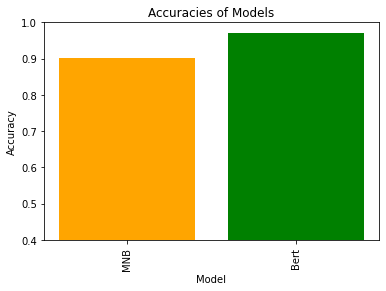

In [ ]:
Model=['MNB', 'Bert']
acc = metrics_df['Accuracy']
Index = [1,2]
fig, ax = plt.subplots()
ax.set(ylim=[0.4, 1.0])
plt.bar(Index,acc, color = ['orange', 'green'])
plt.xticks(Index, Model, rotation=90)
plt.ylabel('Accuracy')
plt.xlabel('Model')
plt.title('Accuracies of Models')
plt.show

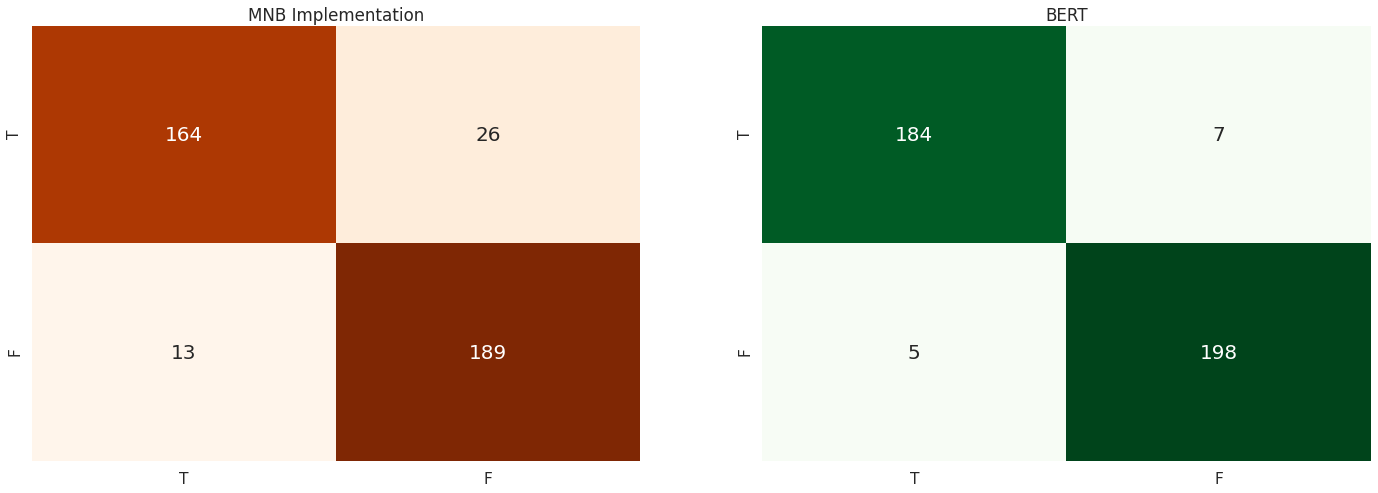

In [ ]:
x_axis_labels = ['T','F'] # labels for x-axis
y_axis_labels = ['T','F'] # labels for y-axis
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(24, 8))

df_cm1 = pd.DataFrame(matrices[0], range(2), range(2))
sns.set(font_scale=1.4) # for label size
sns.heatmap(df_cm1, annot=True,annot_kws={"size": 20}, fmt='g', cmap='Oranges', 
            cbar= False, xticklabels=x_axis_labels, yticklabels=y_axis_labels, ax = ax1) # font size


df_cm2 = pd.DataFrame(matrices[1], range(2), range(2))
sns.set(font_scale=1.4) # for label size
sns.heatmap(df_cm2, annot=True, annot_kws={"size": 20}, fmt='g', cmap='Greens', 
           cbar= False, xticklabels=x_axis_labels, yticklabels=y_axis_labels, ax = ax2) # font size


ax1.set_title('MNB Implementation')
ax2.set_title('BERT')
plt.show()            

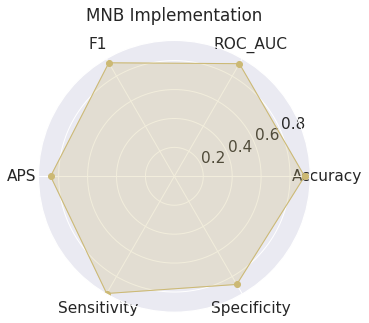

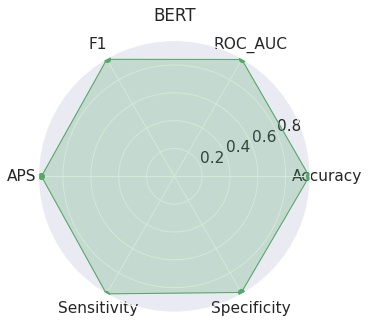

In [ ]:
  labels= metrics_columns[1:]
  stats= metrics_df.loc[0 ,labels] 

  angles=np.linspace(0, 2*np.pi, len(labels), endpoint=False)
  # close the plot
  stats=np.concatenate((stats,[stats[0]]))
  angles=np.concatenate((angles,[angles[0]]))


  fig=plt.figure(figsize= [5,5])
  ax = fig.add_subplot(111, polar=True)
  ax.plot(angles, stats, 'o-', linewidth=1, color = 'y')
  ax.fill(angles, stats, alpha=0.25, color = 'y')
  ax.set_thetagrids(angles * 180/np.pi, labels)
  ax.set_title(metrics_df.loc[0 ,"Algorithm"]) 
  ax.grid(True)
##########################################################################################################
  labels= metrics_columns[1:]
  stats= metrics_df.loc[1 ,labels] 


  angles=np.linspace(0, 2*np.pi, len(labels), endpoint=False)
  # close the plot
  stats=np.concatenate((stats,[stats[0]]))
  angles=np.concatenate((angles,[angles[0]]))



  fig=plt.figure(figsize= [5,5])
  ax = fig.add_subplot(111, polar=True)
  ax.plot(angles, stats, 'o-', linewidth=1, color = 'g')
  ax.fill(angles, stats, alpha=0.25, color = 'g')
  ax.set_thetagrids(angles * 180/np.pi, labels)
  ax.set_title(metrics_df.loc[1 ,"Algorithm"]) 
  ax.grid(True)